# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Toxic Comment Classification with CNN

Benchmark Implementation

In this step, we did the following:
* train the menchmark model
* run the prediction on the unseen test dataset
* plot the roc curves

removing stop words

removing IPs, usernames and URL links

The TfidfVectorizer has the following parameters:
* sublinear_tf=True - Apply sublinear tf scaling. Replace tf with 1 + log(tf)
* strip_accents='unicode' - Remove accents and perform other character normalization with 'unicode' method
* analyzer='word' - feature is made of word
* ngram_range=(1,1) - set the lower and upper boundary of the range of n-values for different n-grams to be extracted
* max_features=100000 - Consider on the top max_features ordered by term frequency across the train corpus

The sklearn LogisticRegression is used with the default parameters:
* (penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None

The fitting use the following:
* cross validation=3
* scoring metrics: sklearn roc_auc

The following input files are located in the same directory as this notebook. 

1. train.csv - the training set, contains comments with their binary labels
2. test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
3. test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

Output files
1. The prediction results are saved as csv file at the location pointed by save_path variable.

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [2]:
# List label names
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Read in train and test datasets from Kaggle provided files
train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')

# merge test comments with test tables
test_all = pd.merge(test_cm, test_lb, on='id')
test_all = test_all.reset_index(drop=True)

# filter out entries not used for scoring
test = test_all[test_all['toxic'] != -1]

# Get comments text from train and test
X_train = train['comment_text']
X_test = test['comment_text']

# Combine both train and test comments
all = pd.concat([X_train, X_test])


In [3]:
# Removing ip address
X_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
X_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
# Removing url link
X_train = X_train.apply(lambda x: re.sub("http://.*com","",x))
X_test = X_test.apply(lambda x: re.sub("http://.*com","",x))
# Removing username
X_train = X_train.apply(lambda x: re.sub("\[\[.*\]","",x))
X_test = X_test.apply(lambda x: re.sub("\[\[.*\]","",x))

In [4]:
# Vectorize the train dataset and transform both train and test datasets to features
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=100000)
word_vectorizer.fit(X_train)
X_train = word_vectorizer.transform(X_train)
X_test = word_vectorizer.transform(X_test)

In [5]:
# Use LogisticRegression classifier to fit the train data with cross-validation
# Perform prediction with test dataset and generate roc_auc score

cv_scores = []
#scores = []
d_pred = dict()
    
for i,label_name in enumerate(label_names):
    train_target = train[label_name]
    clf = LogisticRegression(random_state=8)

    cv_score = np.mean(cross_val_score(clf, X_train, train_target, cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for label {} is {}'.format(label_name, cv_score))

    clf.fit(X_train, train_target)
    d_pred[i] = clf.predict_proba(X_test)[:, 1]
    
    #score = roc_auc_score(test[label_name], d_pred[i])
    #scores.append(score)
    
    #print('Test roc_auc score for label {} is {}'.format(label_name, score))

print('Total CV score is {}'.format(np.mean(cv_scores)))
#print('Total test roc_auc score is {}'.format(np.mean(scores)))

CV score for label toxic is 0.9698922958939474
CV score for label severe_toxic is 0.985415379357601
CV score for label obscene is 0.985571994973056
CV score for label threat is 0.9817705287495109
CV score for label insult is 0.9765471761960279
CV score for label identity_hate is 0.9748481669940511
Total CV score is 0.9790075903606991


<Figure size 720x576 with 0 Axes>

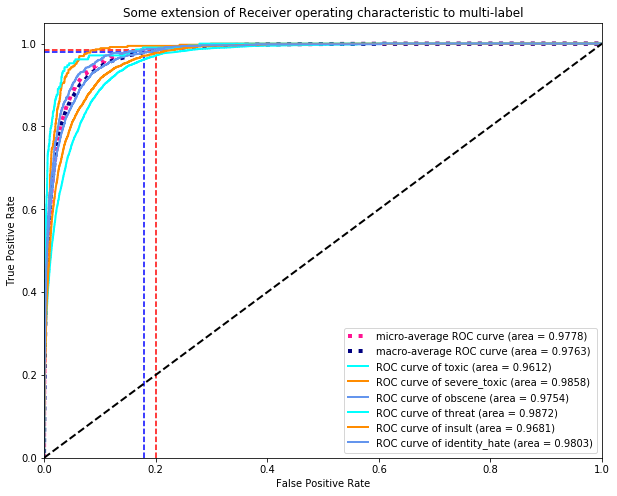

In [6]:
# Compute ROC curve and AUC for test
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Define plot size
plt.figure(figsize=(10,8))
lw = 2

fpr = dict()
tpr = dict()
rocauc = dict()
y_test = np.column_stack([test[i] for i in label_names])
y_pred = np.column_stack([d_pred[i] for i in range(len(d_pred))])
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    rocauc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
rocauc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_test.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
rocauc["macro"] = auc(fpr["macro"], tpr["macro"])

# index of the first threshold for which the sensitivity > 0.98
idx1 = np.min(np.where(tpr["macro"] > 0.98)) 
# index of the first threshold for which the fall out < 0.20
idx2 = np.max(np.where(fpr["macro"] < 0.20)) 

# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0,fpr["macro"][idx1]], [tpr["macro"][idx1],tpr["macro"][idx1]], 'k--', color='blue')
plt.plot([fpr["macro"][idx1],fpr["macro"][idx1]], [0,tpr["macro"][idx1]], 'k--', color='blue')

plt.plot([0,fpr["macro"][idx2]], [tpr["macro"][idx2],tpr["macro"][idx2]], 'k--', color='red')
plt.plot([fpr["macro"][idx2],fpr["macro"][idx2]], [0,tpr["macro"][idx2]], 'k--', color='red')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(y_test.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(label_names[i], rocauc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-label')
plt.legend(loc="lower right")
plt.show()

In [8]:
save_path = 'logistic-regression-stopwords-clean-dot9763.csv'
pred_save = test.copy()
pred_save[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
pred_save.to_csv(save_path, index=False)
pred_test = pd.read_csv(save_path)
pred_test = pred_test[label_names]
score = roc_auc_score(y_test, pred_test)
print("\n roc_auc score: %.6f \n" % (score))


 roc_auc score: 0.976340 

